**Project Machine Learning II - Roissyah Fernanda Khoiroh**

The first step, we can prepare the dataset. In this case, I download the dataset from Kaggle using `opendatasets`. After the dataset has been downloaded, we can import all required libraries that can support our data wraingling, data visualization, and model building.

In [1]:
!pip install opendatasets -q

In [2]:
import opendatasets as od

od.download(
    "https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fernanda52
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


100%|██████████| 24.3M/24.3M [00:00<00:00, 116MB/s] 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/content/book-recommendation-dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

/content/book-recommendation-dataset/Books.csv
/content/book-recommendation-dataset/classicRec.png
/content/book-recommendation-dataset/Ratings.csv
/content/book-recommendation-dataset/Users.csv
/content/book-recommendation-dataset/DeepRec.png
/content/book-recommendation-dataset/recsys_taxonomy2.png


Next, we can check how's the dataset look like by utilizing `pd.read_csv` from pandas.

In [4]:
# read csv
books = pd.read_csv('/content/book-recommendation-dataset/Books.csv')
ratings = pd.read_csv('/content/book-recommendation-dataset/Ratings.csv')
users = pd.read_csv('/content/book-recommendation-dataset/Users.csv')

<ipython-input-4-c10e1d0da5de>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('/content/book-recommendation-dataset/Books.csv')


In [5]:
my_df = [books, ratings, users]

# check df info
for file in my_df:
    print(file.info())
    print('*****'*8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB
None
****************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1

From this quick exploration using `pd.info()`, we can check our data condition. Is it contain missing values, how's the dtype?.

We can see that, in `Books.csv` some values are missing, in these columns: 'Book-Author', 'Publisher', and 'Image-URL-L'. There's no missing values in `Ratings.csv`. Meanwhile, in `Users.csv`, 39.7% values in Age column are missing.

We must handle those missing value. The first thing we can consider, is by checking whether we're going to use the column for further analysis or even for model creation, if we need that, we must do data cleaning, otherwise just skip cleaning the column and we can drop that unused columns'.

# **Data Cleaning**

## **Books.csv**

In [6]:
books.isnull().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,3


In [7]:
# drop image URL columns, as we don't need it
books = books.drop(columns=['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)

books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


In [8]:
# as the number of missing value in Book-Author and Publisher is just 2, let's drop them
books = books.dropna(subset=['Book-Author', 'Publisher'])
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271356 non-null  object
 1   Book-Title           271356 non-null  object
 2   Book-Author          271356 non-null  object
 3   Year-Of-Publication  271356 non-null  object
 4   Publisher            271356 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


In [9]:
# check uniqe value in Year-Of-Publication
print(books['Year-Of-Publication'].unique())

# 2 publishers shouldn't exist in this variable.
# apart from that, we also still have 0 value, and year with quotation mark
# once all cleaning proses done, we can convert dtype from object to int

[2002 2001 1991 1999 2000 1993 1996 1988 2004 1998 1994 2003 1997 1983
 1979 1995 1982 1985 1992 1986 1978 1980 1952 1987 1990 1981 1989 1984 0
 1968 1961 1958 1974 1976 1971 1977 1975 1965 1941 1970 1962 1973 1972
 1960 1966 1920 1956 1959 1953 1951 1942 1963 1964 1969 1954 1950 1967
 2005 1957 1940 1937 1955 1946 1936 1930 2011 1925 1948 1943 1947 1945
 1923 2020 1939 1926 1938 2030 1911 1904 1949 1932 1928 1929 1927 1931
 1914 2050 1934 1910 1933 1902 1924 1921 1900 2038 2026 1944 1917 1901
 2010 1908 1906 1935 1806 2021 '2000' '1995' '1999' '2004' '2003' '1990'
 '1994' '1986' '1989' '2002' '1981' '1993' '1983' '1982' '1976' '1991'
 '1977' '1998' '1992' '1996' '0' '1997' '2001' '1974' '1968' '1987' '1984'
 '1988' '1963' '1956' '1970' '1985' '1978' '1973' '1980' '1979' '1975'
 '1969' '1961' '1965' '1939' '1958' '1950' '1953' '1966' '1971' '1959'
 '1972' '1955' '1957' '1945' '1960' '1967' '1932' '1924' '1964' '2012'
 '1911' '1927' '1948' '1962' '2006' '1952' '1940' '1951' '1931' '1954

What happened in above code are:
1. drop 'Image-URL-S', 'Image-URL-M', 'Image-URL-L' as we don't need it
2. for 2 missing value in 'Publisher', we can drop it, as the number is so small and we can't fill out the mising value with mode, because this is prone to error
3. when we check 'Year-Of-Publication', there are inconsistent values, we can see there are 0, and Publisher there, and some year have quotation mark. Before doing any further analysis, we must handle these inconsistent values

### **cleaning 'DK Publishing Inc'**

In [10]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc', :]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


In [11]:
# replace 'DK Publishing Inc' with year
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [12]:
# rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


In [13]:
sum(books['Year-Of-Publication'] == 'DK Publishing Inc')

0

### **cleaning 'Gallimard'**

In [14]:
books.loc[books['Year-Of-Publication'] == 'Gallimard', :]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [15]:
# making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

In [16]:
# rechecking
books.loc[books.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


In [17]:
sum(books['Year-Of-Publication'] == 'Gallimard')

0

This is how we handle wrong values in 'Year-Of-Publication'.

First, we need to check the respective wrong 'Year': 'DK Publishing Inc' and 'Gallimard'. It looks like, the placement of the value is reversed, the year of pubslished should be placed in the 'Year-Of-Publication' column, as well as the author placed in the 'Book-Author' column, and publisher should be placed in 'Publisher' column. What happens is that the year is placed in the author, and vice versa.

Second, we just need to fill in the right value in the right column by utilizing `.loc` from pandas, and the problem is solved.

### **remove quotation marks in Year-Of-Publication**

In [18]:
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

In [19]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

In [20]:
books[books['Year-Of-Publication'] > 2006].value_counts()

,,,,,count
ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,
0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA,1
068107468X,Edgar Allen Poe Collected Poems,Edgar Allan Poe,2020,Bausch &amp; Lombard,1
0870449842,Crossing America,National Geographic Society,2030,National Geographic,1
0870446924,"Field Guide to the Birds of North America, 3rd Ed.",National Geographic Society,2030,National Geographic,1
074349346X,Angels &amp; Demons : A Novel,Dan Brown,2008,Washington Square Press,1
0743474198,Heartbreaker,Julie Garwood,2010,Pocket,1
0743457226,Deep Waters,Jayne Ann Krentz,2010,Pocket,1
068471941X,LOOK HOMEWARD ANGEL,T Wolfe,2020,Scribner Paper Fiction,1
068471809X,To Have and Have Not,Ernest Hemingway,2037,Simon &amp; Schuster,1


The way we handle quotation mark in 'Year-Of-Publication', which imply the year has object dtype, is by utilizing `pd.to_numeric`, it will automatically convert string to number (int).

If we check carefully, some books are published in the future: 2050, 2030, 2037. We must filter the data, to drop those nonsense Year. One more, 0 value in 'Year-Of-Publication' has to be treated as well.

### **handling 0 and invalid year (ex: 2050, 2038, 2027, 2037)**

In [21]:
# setting invalid years as NaN
books.loc[(books['Year-Of-Publication'] > 2006) | (books['Year-Of-Publication'] == 0), 'Year-Of-Publication'] = np.nan

# replacing NaN with median value of Year-Of-Publication
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)

# reset the dtype as int32
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(np.int32)

<ipython-input-21-38858d4e1e35>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)


In [22]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 1925, 1948,
       1943, 1947, 1945, 1923, 1939, 1926, 1938, 1911, 1904, 1949, 1932,
       1928, 1929, 1927, 1931, 1914, 1934, 1910, 1933, 1902, 1924, 1921,
       1900, 1944, 1917, 1901, 1908, 1906, 1935, 1806, 2006, 1909, 1378,
       1919, 1922, 1897, 1376], dtype=int32)

In [23]:
books['Book-Title'].unique()[:50] # the book title is clean

array(['Classical Mythology', 'Clara Callan', 'Decision in Normandy',
       'Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It',
       'The Mummies of Urumchi', "The Kitchen God's Wife",
       "What If?: The World's Foremost Military Historians Imagine What Might Have Been",
       'PLEADING GUILTY',
       'Under the Black Flag: The Romance and the Reality of Life Among the Pirates',
       "Where You'll Find Me: And Other Stories",
       'Nights Below Station Street',
       "Hitler's Secret Bankers: The Myth of Swiss Neutrality During the Holocaust",
       'The Middle Stories', 'Jane Doe',
       "A Second Chicken Soup for the Woman's Soul (Chicken Soup for the Soul Series)",
       'The Witchfinder (Amos Walker Mystery Series)',
       'More Cunning Than Man: A Social History of Rats and Man',
       'Goodbye to the Buttermilk Sky', 'The Testament',
       'Beloved (Plume Contemporary Fiction)',
       "Our Dumb Century: The Oni

In [24]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271356 non-null  object
 1   Book-Title           271356 non-null  object
 2   Book-Author          271356 non-null  object
 3   Year-Of-Publication  271356 non-null  int32 
 4   Publisher            271356 non-null  object
dtypes: int32(1), object(4)
memory usage: 11.4+ MB


So, how do we handle those nonsense 'Year-Of-Publication'? simply just by setting invalid years as NaN, then we can replace NaN with median value of Year-Of-Publication , and lastly reset the dtype as int32.

## **Ratings.csv**

In [25]:
ratings.duplicated().sum()

0

In [26]:
ratings['Book-Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [27]:
# only take rows with Book-Rating != 0 (explicit rating)
ratings_new = ratings[ratings['Book-Rating'] != 0]

print(ratings_new.shape) # wow, we dropped many rows

(433671, 3)


In [28]:
ratings_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 433671 entries, 1 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   User-ID      433671 non-null  int64 
 1   ISBN         433671 non-null  object
 2   Book-Rating  433671 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 13.2+ MB


Although there are implicit ratings marked with a value of 0, this project only uses explicit ratings with a value of 1-10 in order to focus the model on processing only explicit ratings that indicate the user's satisfaction with the purchased book.

Therefore, we can filter the dataset by only using rows that have a rating not equal to zero.

## **Users.csv**

In [29]:
users['Age'].isnull().sum() # 39.7% values are missing

110762

<Axes: >

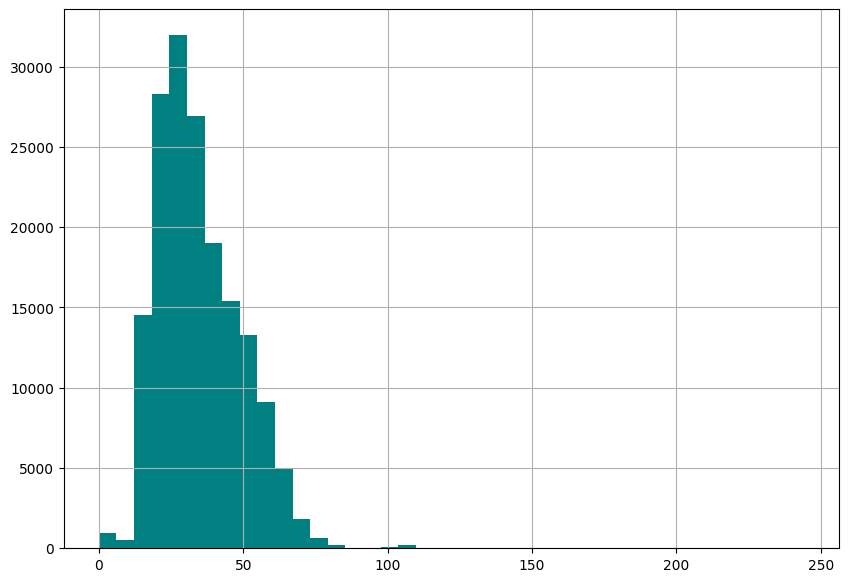

In [30]:
plt.figure(figsize=(10, 7))
users.Age.hist(bins=40, color='teal')

In [31]:
# age less than 5, and greater than 90 doesn't make sense
# let's replace them with its median

users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

# replacing NaN with median
users.Age = users.Age.fillna(users.Age.median())

# setting the data type as int
users.Age = users.Age.astype(np.int32)

<Axes: >

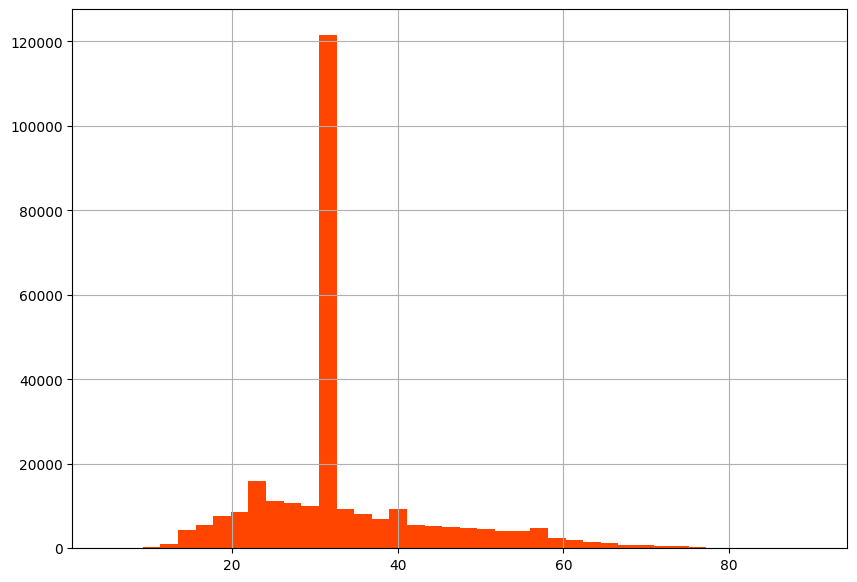

In [32]:
plt.figure(figsize=(10, 7))
users.Age.hist(bins=40, color='orangered')

In [33]:
users.Location[:15]

,Location
0,"nyc, new york, usa"
1,"stockton, california, usa"
2,"moscow, yukon territory, russia"
3,"porto, v.n.gaia, portugal"
4,"farnborough, hants, united kingdom"
5,"santa monica, california, usa"
6,"washington, dc, usa"
7,"timmins, ontario, canada"
8,"germantown, tennessee, usa"
9,"albacete, wisconsin, spain"


In [34]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   User-ID   278858 non-null  int64 
 1   Location  278858 non-null  object
 2   Age       278858 non-null  int32 
dtypes: int32(1), int64(1), object(1)
memory usage: 5.3+ MB


As we can see, 39.7% values in 'Age' are missing. We can also observe that there are users with age less than 5, and greater than 90 which is doesn't make sense.

We can replace those invalid age by: setting invalid years as NaN, then replace NaN with median value of 'Age', and lastly reset the dtype as int32.

After cleaning, we find that the age distribution in the dataset is the age of 30 dominating to reach 120000, then contributed by users under the age of 30, namely 15-29 years, and users over the age of 30 with an age range of 31-75 years. This indicates that users on the platform are very varied because they embrace teenagers, adults, parents, and the elderly.

# **EDA**

In [35]:
combined = pd.merge(
    books,
    ratings_new,
    on = 'ISBN'
)
print(combined.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383838 entries, 0 to 383837
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 383838 non-null  object
 1   Book-Title           383838 non-null  object
 2   Book-Author          383838 non-null  object
 3   Year-Of-Publication  383838 non-null  int32 
 4   Publisher            383838 non-null  object
 5   User-ID              383838 non-null  int64 
 6   Book-Rating          383838 non-null  int64 
dtypes: int32(1), int64(2), object(4)
memory usage: 19.0+ MB
None


In order to make our exploratory data analysis easier, we can merge the two csv: `Books.csv`, and `Ratings.csv` on 'ISBN' column.

In [37]:
def make_horizontal_barplot(column, column_name):

    # Create a horizontal bar plot using Seaborn and Matplotlib
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Use the barplot function from Seaborn
    ax = sns.countplot(y=column, palette="viridis")

    # Add labels and title
    ax.set(xlabel='Count', ylabel='Categories', title=f'Countplot of {column_name}')

    # Show the plot
    plt.show()

In [38]:
def barplot_top_10(column, column_name):
    # Get value counts of the column
    make_counts = column.value_counts()

    # Get top 10 values
    make_counts = make_counts[:10]

    # Create a horizontal bar plot using Seaborn and Matplotlib
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    # Use the barplot function from Seaborn
    ax = sns.barplot(x=make_counts.values, y=make_counts.index, palette="viridis")

    # Add labels and title
    ax.set(xlabel='Count', ylabel='Categories', title=f'Top 10 {column_name}')

    # Show the plot
    plt.show()

<ipython-input-37-adb5fb493a62>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y=column, palette="viridis")


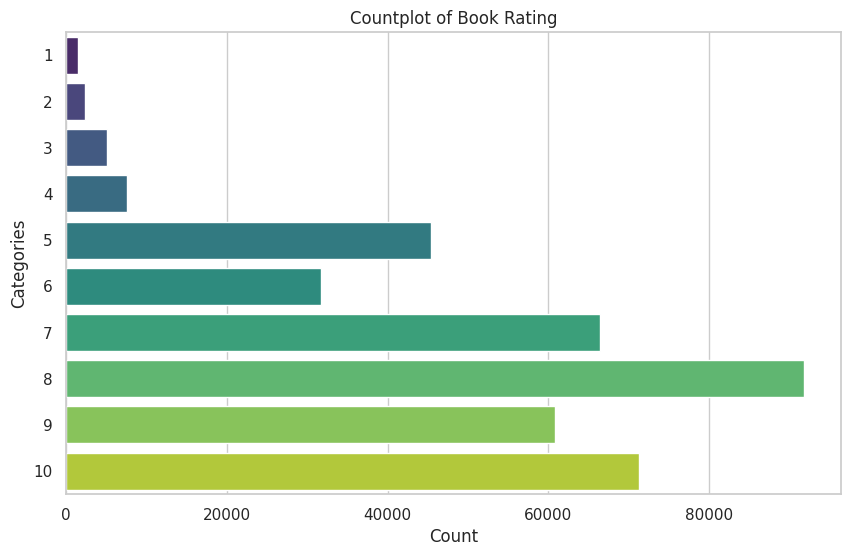

In [39]:
make_horizontal_barplot(combined['Book-Rating'], 'Book Rating')

Rating 8 is the highest, reaching 90000, followed by ratings 10, 7, and 9. This means that users are satisfied and like the books they buy. Meanwhile, there are still users who give low ratings, namely ratings 4, 3, 2 and even 1 even though the total number is less than 18000 people. It is necessary to explore the causes, so that in the future users who give low ratings can improve their user experience so that they are expected to give higher ratings.

<ipython-input-38-7e7027f8535a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=make_counts.values, y=make_counts.index, palette="viridis")


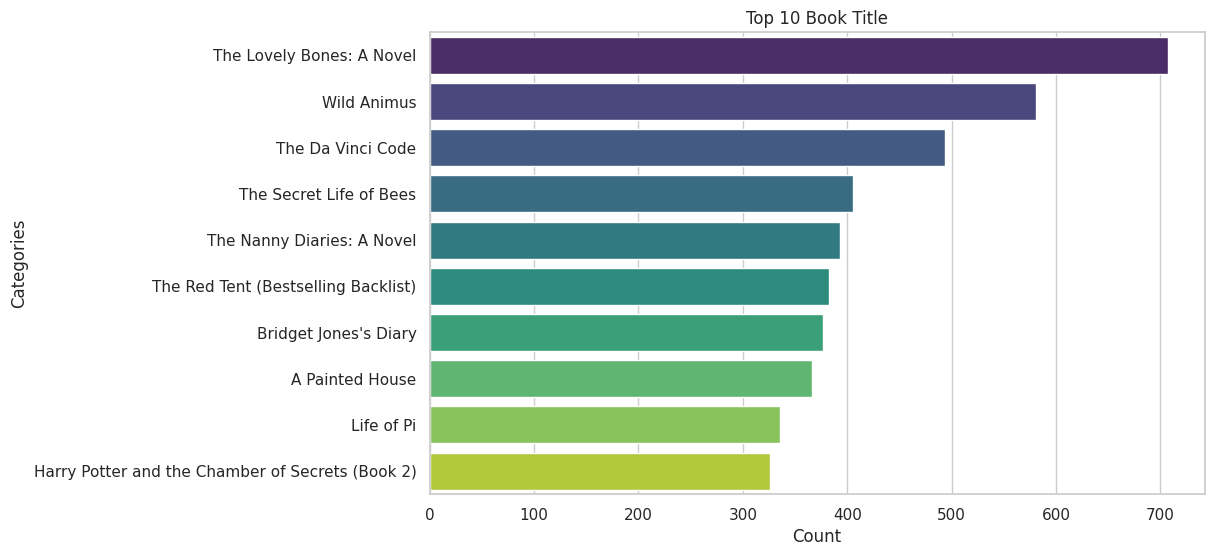

In [40]:
barplot_top_10(combined['Book-Title'], 'Book Title')

'The Lovely Bones: A Novel' topped the popular book charts.

<ipython-input-38-7e7027f8535a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=make_counts.values, y=make_counts.index, palette="viridis")


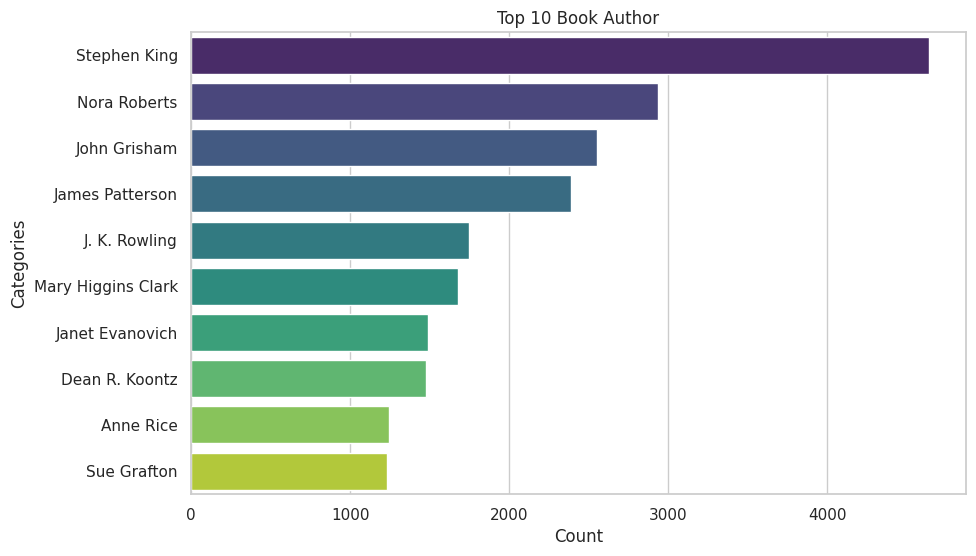

In [41]:
barplot_top_10(combined['Book-Author'], 'Book Author')

Stephen King became the number 1 author.

<ipython-input-38-7e7027f8535a>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=make_counts.values, y=make_counts.index, palette="viridis")


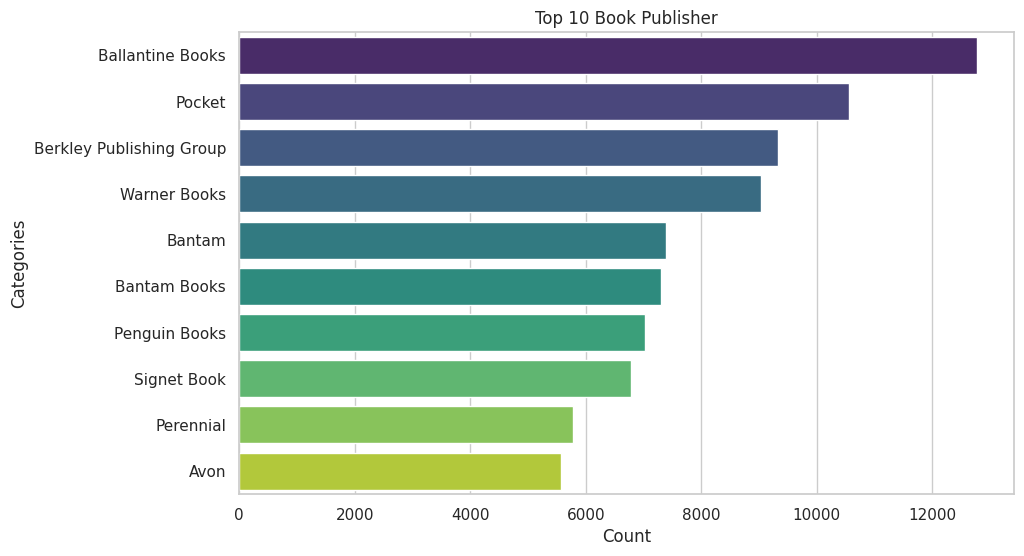

In [42]:
barplot_top_10(combined['Publisher'], 'Book Publisher')

Ballantine Books is the number 1 publisher.

# **Content-based filtering using KNN**

The amount of data in Books.csv and Ratings.cv, which reaches hundreds of thousands, will burden computing and is prone to automatic restart of the kernel. Therefore, random samples are taken from both datasets, by only taking 0.1 of the entire dataset. Next, we merged the data from sample Books.csv with sample Ratings.csv, by using merge on the ISBN column. The merged dataset is obtained with a total of 30055 rows, and a total of 7 columns.

In [43]:
#take sample from ratings and users to save computation resources
users_sample = users.sample(frac=0.1, random_state=42)
books_sample = books.sample(frac=0.1, random_state=42)
print(books_sample.shape)
print(users_sample.shape)

(27136, 5)
(27886, 3)


In [44]:
filtered_df = books_sample.merge(ratings_new, on = 'ISBN')

knn_df = filtered_df.sample(frac=0.8, random_state=42)
print(knn_df.shape)

(30055, 7)


In [45]:
df_pivot = knn_df.pivot_table(index='Book-Title', columns='User-ID', values='Book-Rating').fillna(0)
df_pivot.shape

(12700, 14060)

In [46]:
df_pivot

User-ID,8,14,53,87,88,99,114,129,141,183,...,278582,278620,278633,278641,278648,278663,278694,278724,278832,278843
Book-Title,,,,,,,,,,,,,,,,,,,,,
"Little Comic Shop of Horrors (Give Yourself Goosebumps, Book 17)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Summonings: Books of Magic, Vol. 2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"'night, Mother : A Play (Mermaid Dramabook)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'til the Real Thing Comes Along,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1,000 Makers of the Millennium: The Men and Women Who Have Shaped the Last 1,000 Years",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ã?kotopia: Notizen und Reportagen von William Weston aus dem Jahre 1999 [sic],0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ã?ngeles fugaces (Falling Angels),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ã?rsringen: Roman,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After that, the merged dataset is transformed into a pivot table, with index='Book-Title', columns='User-ID', and the value filling the cells is Book-Rating, with zero values filling the empty cells. Before entering the KNN model, the pivot table will be converted to sparse-matrix form to store data containing a large number of zero-valued elements, so as to save a large amount of memory and speed up data processing.

Implementing K-NN is quite easy, by calling NearestNeighbors from the sklearn.neighbors library. To find the most similar books characterized by their close proximity, a k-NN model is created using the cosine-similarity metric with a brute-force algorithm.

In [47]:
# Import the necessary libraries
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Convert the pivot table to a sparse matrix format
df_matrix = csr_matrix(df_pivot.values)

# Create a NearestNeighbors model using cosine similarity and brute-force algorithm
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit the model to the data (i.e., the sparse matrix)
model_knn.fit(df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

This function generates book recommendations using a content-based filtering approach with K-Nearest Neighbors (KNN). It takes a book title as input (or randomly selects one) and retrieves its index in the pivot table. Using the pre-fitted KNN model, the function identifies the six nearest neighbors to the selected book based on the cosine similarity of their features. The recommendations (excluding the selected book itself) are then printed, showing the titles of the similar books along with their computed distances. This approach helps find books with similar characteristics to the input title for personalized recommendations.

In [48]:
def give_rec_knn(book_title = np.random.choice(df_pivot.index), df_pivot=df_pivot):

  # Print the selected book title
  print(f"Randomly selected book title: {book_title} \n")

  # Find the row index of the selected row title
  query_index = df_pivot.index.get_loc(book_title)

  # Use the fitted KNN model to find the 6 nearest neighbors to the selected row
  distances, indices = model_knn.kneighbors(df_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

  # Print the recommendations for the selected row
  print(f"Recommendations for {df_pivot.index[query_index]}:\n")

  # Iterate over the nearest neighbors and print their names and distances
  for i, (distance, index) in enumerate(zip(distances.flatten()[1:], indices.flatten()[1:])):
    print(f"{i+1}: {df_pivot.index[index]}, with distance of {distance}")

In [ ]:
give_rec_knn(" Summonings: Books of Magic, Vol. 2")
give_rec_knn()

Randomly selected book title:  Summonings: Books of Magic, Vol. 2 

Recommendations for  Summonings: Books of Magic, Vol. 2:

1: Understanding the new European Community, with distance of 0.1258427238784623
2: Books of Magic, The: Death After Death - Book 7 (Books of Magic), with distance of 0.1258427238784623
3: League of Extraordinary Gentlemen, Vol. 2 (Comic), with distance of 0.3099820157578147
4: The Great Gatsby (World's Classics), with distance of 0.46331934558941146
5: Preacher: Gone to Texas (Vertigo), with distance of 0.47788960189258445
Randomly selected book title: Death Qualified (Barbara Holloway Novels (Paperback)) 

Recommendations for Death Qualified (Barbara Holloway Novels (Paperback)):

1: La Chambre indienne, with distance of 0.7207980748960896
2: Bib My Utmost Devotional Bible New King James Version, with distance of 0.7207980748960896
3: Rainsong, with distance of 0.7207980748960896
4: Hellified, with distance of 0.7207980748960896
5: LA Rebelion De Los Enanos (D

In this project, content-based filtering is also implemented by calculating cosine-similarity, the processing stage of which involves the use of TF-IDF (Term Frequency and Inverse Document Frequency).

In [49]:
# initialize TfIDF vectorizer for Book-Author
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(books_sample['Book-Author'])
print(f"the shape of the tfidf matrix is {tfidf_matrix.shape}")

# save in dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.todense(),
                        columns=tfidf.get_feature_names_out(),
                        index=books_sample['Book-Title'])

tfidf_df.sample(10, axis=1).sample(10, axis=0)

the shape of the tfidf matrix is (27136, 13865)


,dudgeon,francis,margo,atlas,skinner,ayres,salton,seely,postman,bridgwood
Book-Title,,,,,,,,,,
God's Cookn' and the Devils' Well Done,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chemical Reaction Heartbeat (Reader's Choice),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Chesapeake in the Seventeenth Century,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Survivors of an Open Marriage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Death of a Gossip (Hamish Macbeth Mysteries (Paperback)),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Eminent Elizabethans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The black cat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Heart of Stone,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grover's Own Alphabet (Little Golden Book),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

TF-IDF in this project is calculated using TfidfVectorizer() to convert the text of the Book-Author column of the sample dataset into a numerical representation based on term frequency and term importance in the entire dataset. The resulting matrix has dimensions according to the number of documents (rows) and features (columns), this matrix is then converted into a Pandas DataFrame where the columns represent features (words) and the index is the book title from the Book-Title column. Next, the similarity between books is calculated using cosine similarity.

In [51]:
cosine_sim_df = pd.DataFrame(cosine_sim,
                             index=books_sample['Book-Title'],
                             columns=books_sample['Book-Title'])

print(f"the shape of the cosine_sim matrix is {cosine_sim_df.shape}")
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

the shape of the cosine_sim matrix is (27136, 27136)


Book-Title,Finding True Love: The Four Essential Keys to Discovering the Love of Your Life,"Junie B. Jones and Some Sneaky Peeky Spying (Junie B. Jones 4, paper)",Heart Magic : Keeping Love Alive &amp; Well,"Contract Killer: The Explosive Story of the Mafia's Most Notorious Hitman Donald \Tony the Greek\"" Frankos""",Scottish Hauntings (A Piccolo Original),Spirit of the Silent Butler,Are You Ready Yet? Preparing for a New Relationship,My Body Lies over the Ocean (Sarah Deane Mysteries),Leaves Change Colors (Scholastic Science Readers: Level 1 (Paperback)),King Camp Gillette 1855-1932: Inventor of the Disposable Culture (Short Lives)
Book-Title,,,,,,,,,,
"Across Time (Big Book) (Harlequin Historical, No 203)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
All About Green Tea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Art of Seduction,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anne of Avonlea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Unholy War: Terror in the Name of Islam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Laurie Blum's Free Money for Childhood Behavioral and Genetic Disorders (Blum, Laurie//Free Money for Child Care Series)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
House of Glory: Finding Personal Meaning in the Temple,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Lovelock (The Mayflower Trilogy, Book 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Why Employees Don't Do What They're Supposed To Do and What To Do About It,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This function generates content-based recommendations for a given book title using cosine similarity. First, it checks if the specified `book_title` exists in the similarity matrix columns (`similarity_data`). If not, it warns the user and returns an empty DataFrame. If the book exists, it identifies the indices of the top `k` most similar books (excluding the input book itself) by partially sorting the cosine similarity values in descending order. These indices are used to extract the titles of the closest books, which are then stored in a DataFrame. Finally, it merges these recommendations with the `items` DataFrame to include additional metadata (like book authors) and returns the top `k` recommendations.

In [57]:
def author_recommendations(book_title, similarity_data=cosine_sim_df, items=books_sample[['Book-Title', 'Book-Author']], k=10):
    # Check if the book_title exists in the similarity matrix columns
    if book_title not in similarity_data.columns:
        print(f"Warning: Book '{book_title}' not found in the similarity matrix. Returning empty recommendations.")
        return pd.DataFrame()  # Return an empty DataFrame

    index = similarity_data.loc[:,book_title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(book_title, errors='ignore')

    # Rename the column in the closest DataFrame
    closest_df = pd.DataFrame(closest, columns=['Book-Title'])

    return closest_df.merge(items, on='Book-Title').head(k)

In [59]:
author_recommendations("James Herriot's Yorkshire").drop_duplicates()

,Book-Title,Book-Author
0,Let Sleeping Vets Lie (G K Hall Large Print Bo...,James Herriot
1,All Things Wise and Wonderful,James Herriot
2,The Market Square Dog,James Herriot
3,James Herriot's Dog Stories,James Herriot
4,The Murder Room : A Novel (Vintage),P.D. JAMES
5,Black Tower,P. D. James
6,Death of an Expert Witness,P D James
7,Death in Holy Orders,P. D. James
8,Before The Cradle Falls,James F. David
9,The Children of Men,P.D. James


In [73]:
# 'test_data' has book titles read by a user (a list of books read by the same users who read this title), and 'book_title' is the input.

test_data = {
    #"The Lovely Bones: A Novel": ["I Know This Much Is True", "The Secret Life of Bees"],
    #"Divine Secrets of the Ya-Ya Sisterhood: A Novel": ["The Pilot's Wife", 'Where the Heart Is'],
    #"The Red Tent (Bestselling Backlist)": ["The Secret Life of Bees", "The Da Vinci Code"],
    #"The Da Vinci Code": ["The Pilot's Wife", 'Where the Heart Is'],
    "All Things Wise and Wonderful": ["The Market Square Dog", "James Herriot's Dog Stories"],
    "Black Tower": ["Death of an Expert Witness", "Death in Holy Orders"],
    "The Murder Room : A Novel (Vintage)": ["Death in Holy Orders", "The Children of Men"]
    #"Snow Falling on Cedars": ["The Secret Life of Bees", "The Da Vinci Code"],
}

This function evaluates a content-based recommendation system using precision and accuracy as metrics. It takes as input the recommended books, books the user actually read, and a dataset of books with metadata like authors. Precision is calculated by identifying how many recommended books share the same author as any of the user’s actual reads (true positives) versus those that don't (false positives). Accuracy measures the proportion of recommended books by the same author as the first book in the actual reads list compared to the total books by that author in the dataset. The function returns these metrics as a dictionary to assess the system's recommendation quality.

In [77]:
# evaluate content-based filtering with cosine similaity.
# The accuracy calculation process is done by dividing the number of book recommendations generated, divided by the number of books written by the same author, then multiplied by 100.
# Precision = TP/TP+FP
# TP: the recommended book has a similar genre or author to the target book.
# FP: books that are recommended but do not have a similar genre or author.

def evaluate_content_based_filtering(recommendations, actual_reads, books_sample):
    """
    Evaluates the performance of a content-based filtering system.

    Args:
        recommendations: A list of recommended books for a user.
        actual_reads: A list of books actually read by the user.
        books_sample: DataFrame containing book information, including authors.

    Returns:
        A dictionary containing accuracy and precision metrics.
    """

    recommendations_set = set(recommendations)
    actual_reads_set = set(actual_reads)

    # Calculate True Positives (TP) and False Positives (FP)
    tp = 0
    fp = 0

    for recommended_book in recommendations:
        # Find the author of the recommended book
        recommended_author = books_sample[books_sample['Book-Title'] == recommended_book]['Book-Author'].iloc[0]

        # Check if any of the actual reads have the same author
        is_tp = any(books_sample[books_sample['Book-Title'] == actual_read]['Book-Author'].iloc[0] == recommended_author for actual_read in actual_reads_set if actual_read in books_sample['Book-Title'].values)
        if is_tp:
            tp += 1
        else:
            fp += 1

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0

    # Calculate accuracy
    # Number of books written by the same author as the target book
    target_author = books_sample[books_sample['Book-Title'] == list(actual_reads_set)[0]]['Book-Author'].iloc[0]
    same_author_books = books_sample[books_sample['Book-Author'] == target_author]['Book-Title'].tolist()
    num_same_author = len(same_author_books)

    accuracy = (len(recommendations_set.intersection(set(same_author_books))) / num_same_author) * 100 if num_same_author > 0 else 0


    return {"accuracy": accuracy, "precision": precision}

In [78]:
# use above function, to calculate the accuracy and precision with test_data
# author_recommendations is function that returns recommendations

metrics = {}
for book_title, actual_reads in test_data.items():
    recommendations = author_recommendations(book_title)['Book-Title'].tolist()
    metrics[book_title] = evaluate_content_based_filtering(recommendations, actual_reads, books_sample)

for book_title, metric in metrics.items():
    print(f"Metrics for book '{book_title}': {metric}")

# Calculate average precision and accuracy across all test cases
average_precision = np.mean([metric['precision'] for metric in metrics.values()])
average_accuracy = np.mean([metric['accuracy'] for metric in metrics.values()])

print(f"\nAverage Precision: {average_precision}")
print(f"Average Accuracy: {average_accuracy}")

Metrics for book 'All Things Wise and Wonderful': {'accuracy': 80.0, 'precision': 0.4}
Metrics for book 'Black Tower': {'accuracy': 100.0, 'precision': 0.5}
Metrics for book 'The Murder Room : A Novel (Vintage)': {'accuracy': 100.0, 'precision': 0.4}

Average Precision: 0.43333333333333335
Average Accuracy: 93.33333333333333


From the test_data used, we can see that the average precision for our content-based filtering with cosine similarity is 43.33%, and the average accuracy is 93.33%.

# **Collaborative Filtering with Deep Learning Model**

The following steps are required before building a model to predict Book-Rating based on the combination of User-ID and ISBN:
1. As in content-based filtering, only sample data taken randomly from Users.csv and Ratings.csv is used to train this model.
2. Encoding the data object types of ISBN and User-ID so that the model can process them.
3. Create an input feature called x by combining the encoded columns (User-ID-encoded and ISBN-encoded).
4. The target column y (Book-Rating) is normalized in the range [0, 1] using the minimum and maximum rating values.
5. Divide the dataset into training data (80%) and validation data (20%) based on the index.

In [ ]:
# only use 1/5 part of the dataset for training, because of runtime issue
# previously when I use all part of dataset, it failed to do encoding especially encode the Book-ID/ISBN

#df_ratings = ratings.sample(frac=.05, random_state=42)
mydf = ratings.sample(frac=0.01, random_state=42)

print(mydf.shape)

(11498, 3)


In [ ]:
# just in case i need to take sample from users dataset
# but i will just stick to only use mydf, as user-i, isbn, rating available there

users_sample = users.sample(frac=0.1, random_state=42)
print(users_sample.shape)

(27886, 3)


In [ ]:
# encode userid
user_ids = mydf['User-ID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [ ]:
# encode bookid
book_ids = mydf['ISBN'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

In [ ]:
# checking
num_users = len(user_encoded_to_user)
num_books = len(book_encoded_to_book)
print(num_users)
print(num_books)

min_ratings = min(mydf['Book-Rating'])
max_ratings = max(mydf['Book-Rating'])
print(f'Number of User: {num_users}, Number of Books: {num_books}, Min Rating: {min_ratings}, Max Rating: {max_ratings}')

5889
10042
Number of User: 5889, Number of Books: 10042, Min Rating: 0, Max Rating: 10


In [ ]:
mydf['User-ID-encoded'] = mydf['User-ID'].map(user_to_user_encoded)
mydf['ISBN-encoded'] = mydf['ISBN'].map(book_to_book_encoded)

In [ ]:
# User-ID, Book-Rating, Book-Title

# Shuffling dataset
df = mydf.sample(frac=1, random_state=42)

# create x variable, to match up User-ID and Book Title encoded into one value
x = mydf[['User-ID-encoded', 'ISBN-encoded']].values

# split the y
y = mydf['Book-Rating'].apply(lambda x: (x - min_ratings) / (max_ratings - min_ratings)).values

# split dataset
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x.shape, y.shape, x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(11498, 2) (11498,) (9198, 2) (9198,) (2300, 2) (2300,)


In [ ]:
print(x, y)

[[    0     0]
 [    1     1]
 [    2     2]
 ...
 [    9 10039]
 [ 1383 10040]
 [ 1733 10041]] [0.  0.8 0.  ... 0.9 1.  0. ]


In [ ]:
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path

This model uses embedding to map users and books into a low-dimensional vector space. There are two embeddings for each entity: one for users and one for books, both with embedding vectors of size 50 (specified by EMBEDDING_SIZE). Each entity also has a separate bias. In the call function, the model calculates the interaction between the user and book vectors using the dot product operation, then sums it with the user and book biases. The result is processed through a sigmoid activation function to predict the likelihood of the user liking the book. The model is trained using binary cross-entropy as the loss function and optimized with Adam optimizer.

In [ ]:
EMBEDDING_SIZE = 50

class RecommenderNet(tf.keras.Model):

  # function initialization
  def __init__(self, num_users, num_books, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_books = num_books
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # user embedding layer
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-5)
    )
    self.user_bias = layers.Embedding(num_users, 1) # user_bias embedding layer
    self.books_embedding = layers.Embedding( # books_embeddings layer
        num_books,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-5)
    )
    self.book_bias = layers.Embedding(num_books, 1) # book_bias embedding layer

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # calling embedding layer 1
    user_bias = self.user_bias(inputs[:, 0]) # calling embedding layer 2
    book_vector = self.books_embedding(inputs[:, 1]) # calling embedding layer 3
    book_bias = self.book_bias(inputs[:, 1]) # calling embedding layer 4

    dot_user_book = tf.tensordot(user_vector, book_vector, 2)

    x = dot_user_book + user_bias + book_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_users, num_books, EMBEDDING_SIZE) # model init

# model compiling
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# start training

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 28,
    epochs = 30,
    verbose = 1,
    validation_data = (x_val, y_val)
)

Epoch 1/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.6440 - root_mean_squared_error: 0.4113 - val_loss: 0.6912 - val_root_mean_squared_error: 0.4364
Epoch 2/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6337 - root_mean_squared_error: 0.4047 - val_loss: 0.6909 - val_root_mean_squared_error: 0.4361
Epoch 3/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - loss: 0.6220 - root_mean_squared_error: 0.3957 - val_loss: 0.6906 - val_root_mean_squared_error: 0.4358
Epoch 4/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 0.6109 - root_mean_squared_error: 0.3917 - val_loss: 0.6903 - val_root_mean_squared_error: 0.4354
Epoch 5/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.6043 - root_mean_squared_error: 0.3856 - val_loss: 0.6901 - val_root_mean_squared_error: 0.4352
Epoch 6/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.5939 - root_mean_squared_error: 0.3820 - val_loss: 0.6898 - val_root_mean_squared_error: 0.4349
Epoch 7/30
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 1

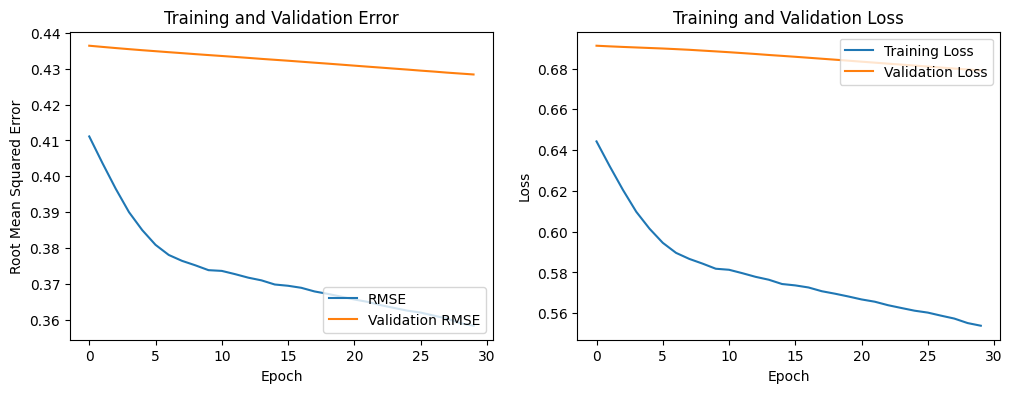

In [ ]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['root_mean_squared_error'],     label='RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('Training and Validation Error')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'],     label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

Using 30 epochs, the training results can be seen in the figure above. The RMSE on the training set is 0.3583, while the RMSE on the validation set is 0.4284.

In [ ]:
book_df = books
ratings_df = ratings_new

# take user sample
user_id = 189973 #ratings_df.user_id.sample(1).iloc[0]
book_read_by_user = ratings_df[ratings_df['User-ID'] == user_id]

# to get ISBN that are not available in the list of book already read
book_not_read = book_df[~book_df['ISBN'].isin(book_read_by_user['ISBN'].values)]['ISBN']
book_not_read = list(
    set(book_not_read)
    .intersection(set(book_to_book_encoded.keys()))
)

book_not_read = [[book_to_book_encoded.get(x)] for x in book_not_read if book_to_book_encoded.get(x) is not None]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_read), book_not_read)
)

In [ ]:
user_book_array

array([[   7, 3777],
       [   7,  421],
       [   7, 7480],
       ...,
       [   7, 4377],
       [   7, 5524],
       [   7, 7071]])

The code generates and displays book recommendations for a user using a collaborative filtering approach with a deep learning model. First, the model predicts ratings for all books in the `user_book_array`, and the predictions are flattened into a one-dimensional array. The top 10 book indices with the highest predicted ratings are determined by sorting the predictions in descending order. These indices are mapped to their corresponding book IDs using a decoding dictionary (`book_encoded_to_book`). The code then prints details of the top-rated books the user has previously interacted with, based on their ratings, and the top 10 recommended books predicted by the model. Book details, such as title and author, are fetched from a dataset (`book_df`) using the relevant book IDs.

In [ ]:
ratings_predicted = model.predict(user_book_array).flatten()

top_ratings_indices = ratings_predicted.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(book_not_read[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Book Title with high ratings from user')
print('----' * 8)

top_book_user = (
    book_read_by_user.sort_values(
        by = 'Book-Rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)

book_df_rows = book_df[book_df['ISBN'].isin(top_book_user)]
for _, row in book_df_rows.iterrows():
    print(row['Book-Title'], ':', row['Book-Author'])

print('----' * 8)
print('Top 10 book recommendation')
print('----' * 8)

recommended_book = book_df[book_df['ISBN'].isin(recommended_book_ids)]
for _, row in recommended_book.iterrows():
    print(row['Book-Title'], ':', row['Book-Author'])

275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Showing recommendations for users: 189973
Book Title with high ratings from user
--------------------------------
The Borrowers : Mary Norton
Don Aslett's Clutter-Free!: Finally &amp; Forever : Don Aslett
Lose 200 Pounds This Weekend : Don Aslett
Not for Packrats Only: How to Clean Up, Clear Out, and Live Clutter-Free Forever : Don Aslett
Eight Hands Round: A Patchwork Alphabet : Ann Whitford Paul
--------------------------------
Top 10 book recommendation
--------------------------------
Bird by Bird: Some Instructions on Writing and Life : Anne Lamott
Le Divorce (William Abrahams Book) : Diane Johnson
Finding You : Carla Neggers
Who Rules America Now?: A View for the 80's : G. William Domhoff
Jungle Book : Rudyard Kipling
Late for the Wedding : Amanda Quick
The Fanatic's Guide to Computers : Roland Fiddy
River of Tomorrow : Dorothy Garlock
Frank Peretti Value Pack : Frank E. Peretti
Vers chez les blancs : Philippe Djian


In [ ]:
recommended_book

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
1519,0385480016,Bird by Bird: Some Instructions on Writing and...,Anne Lamott,1995,Anchor
1565,0452284481,Le Divorce (William Abrahams Book),Diane Johnson,2003,Plume Books
12231,0671883208,Finding You,Carla Neggers,1996,Pocket
16605,0671622358,Who Rules America Now?: A View for the 80's,G. William Domhoff,1986,Simon &amp; Schuster
26467,0812504690,Jungle Book,Rudyard Kipling,1992,Tor Books
79187,0553802712,Late for the Wedding,Amanda Quick,2003,Bantam
112242,1850152713,The Fanatic's Guide to Computers,Roland Fiddy,2000,Exley Giftbooks
118864,0445203668,River of Tomorrow,Dorothy Garlock,1988,Warner Books
126821,0842386564,Frank Peretti Value Pack,Frank E. Peretti,2003,Tyndale House Publishers
187667,2070419444,Vers chez les blancs,Philippe Djian,2001,Gallimard


# **Collaborative Filtering with SVD**

In [ ]:
!pip install scikit-surprise -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from sklearn.model_selection import train_test_split
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix

Basically, the data processing stage in the SVD model is the same as when building the previous model, starting with taking random data samples from Ratings.csv with frac=0.25, and encoding the data object types, namely ISBN and User-ID. Next, the data is converted into a format that can be processed by the Surprise library using the Reader object and the Dataset.load_from_df function. In this case, the dataset is not separated into training set and validation set, but cross-validation with 10 folds is used.

In [ ]:
books_rating = ratings_new.copy()
books_rating = books_rating.sample(frac=0.25, random_state=42)
books_rating.shape

(108418, 3)

In [ ]:
# encode userid
user_ids = books_rating['User-ID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

# encode bookid
book_ids = books_rating['ISBN'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

In [ ]:
# checking
num_users = len(user_encoded_to_user)
num_books = len(book_encoded_to_book)
print(num_users)
print(num_books)

min_ratings = min(books_rating['Book-Rating'])
max_ratings = max(books_rating['Book-Rating'])
print(f'Number of User: {num_users}, Number of Books: {num_books}, Min Rating: {min_ratings}, Max Rating: {max_ratings}')

33885
66448
Number of User: 33885, Number of Books: 66448, Min Rating: 1, Max Rating: 10


In [ ]:
# store encoding result to books_rating
books_rating['user-encoded'] = books_rating['User-ID'].map(user_to_user_encoded)
books_rating['book-encoded'] = books_rating['ISBN'].map(book_to_book_encoded)

In [ ]:
# make reader object
reader = Reader()

# load data from dataframe (my_df)
data = Dataset.load_from_df(books_rating[['user-encoded', 'book-encoded', 'Book-Rating']], reader)

In [ ]:
data

In [ ]:
# cross-validation for model evaluation
results = cross_validate(SVD(), data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

# calculate avg RMSE dan MAE
mean_rmse = results['test_rmse'].mean()
mean_mae = results['test_mae'].mean()

print(f"\nRata-rata RMSE: {mean_rmse:.4f}")
print(f"Rata-rata MAE: {mean_mae:.4f}")

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    3.1919  3.1725  3.1883  3.1817  3.1858  3.2060  3.1733  3.1868  3.2092  3.1866  3.1882  0.0114  
MAE (testset)     2.7571  2.7535  2.7655  2.7625  2.7635  2.7875  2.7418  2.7716  2.7905  2.7773  2.7671  0.0143  
Fit time          2.79    2.74    3.43    3.07    2.78    2.76    3.90    2.84    2.85    2.89    3.00    0.36    
Test time         0.06    0.34    0.11    0.07    0.06    0.06    0.11    0.07    0.06    0.11    0.11    0.08    

Rata-rata RMSE: 3.1882
Rata-rata MAE: 2.7671


The dataset is split into 10 k-fold cross validation, the average RMSE score is 3.1882 while the average MAE score is 2.7671. The training results using Deep Learning in this project are better than using SVD, considering the RMSE score is lower and has a considerable difference.

In [ ]:
# full trainset
trainset = data.build_full_trainset()

# training SVD model
svd = SVD()
svd.fit(trainset)

In [ ]:
# Predict the rating for a specific user and item
user_id = str(189973)  # User ID should be a string
item_id = str(61009059)  # Item ID should be a string (0061009059
predicted_rating = svd.predict(user_id, item_id).est

print(f"Predicted rating for user {user_id} on item {item_id}: {predicted_rating}")

Predicted rating for user 189973 on item 61009059: 5


In [ ]:
# let's see the book rating given by user no 196 (the user already read the book, it's available in the dataset)
user_ratings = books_rating[books_rating['User-ID'] == 189973]
print(user_ratings)

        User-ID        ISBN  Book-Rating  user-encoded  book-encoded
785952   189973  0440222427            1           535           573
785880   189973  0152099905           10           535          2091
786024   189973  0553577875            5           535          4750
785866   189973  0061042781            5           535          4903
785903   189973  0345396456            5           535          5488
785910   189973  0345441788            5           535          9551
785919   189973  038077688X            6           535         15941
786071   189973  0679823115            8           535         16482
786124   189973  0843947462            3           535         17295
786166   189973  1565296818            5           535         22111
785900   189973  0345347269            6           535          6903
785918   189973  0380771586            5           535         23514
786081   189973  0747245614            2           535         12877
786118   189973  0836220854       

In [ ]:
book_df = books
ratings_df = ratings_new

# take user sample
user_id = 189973 #ratings_df.user_id.sample(1).iloc[0]
book_read_by_user = ratings_df[ratings_df['User-ID'] == user_id]

# to get ISBN that are not available in the list of book already read
book_not_read = book_df[~book_df['ISBN'].isin(book_read_by_user['ISBN'].values)]['ISBN']
book_not_read = list(
    set(book_not_read)
    .intersection(set(book_to_book_encoded.keys()))
)

In [ ]:
# how can we make prediction on unread book for a certain user?

# make prediction of unread books
predicted_ratings = []
for book_id in book_not_read:
    predicted_rating = svd.predict(user_id, book_id).est
    predicted_ratings.append((book_id, predicted_rating))

# sorted books based on predicted rating
predicted_ratings.sort(key=lambda x: x[1], reverse=True)

This code generates personalized book recommendations for a specific user using collaborative filtering with Singular Value Decomposition (SVD). For books the user has not yet read (`book_not_read`), it predicts the user's rating for each book by calling the `svd.predict()` function and stores the results as a list of tuples `(book_id, predicted_rating)`. The list is then sorted in descending order by the predicted ratings. The top 10 books with the highest predicted ratings are selected, and their details (e.g., title, author, publication year, publisher) are retrieved from the dataset using the corresponding book IDs. Finally, the recommended books are displayed in a formatted DataFrame, providing a clear and user-friendly output of the recommendations.

In [ ]:
# take top 10 predicted books
top_n = predicted_ratings[:10]
recommended_book_ids = [book_id for book_id, _ in top_n]

# take detail of the book from or dataset
recommended_books = books[books['ISBN'].isin(recommended_book_ids)][['Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']]

# show the recommendation in DataFrame
recommended_books_df = pd.DataFrame(recommended_books)

print(f'\nTop 10 books recommendation for {user_id}:')
recommended_books_df.reset_index(drop=True, inplace=True)
display(recommended_books_df)


Top 10 books recommendation for 189973:


,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,Valentine Rogues (Zebra Regency Romance),Cindy Holbrook,2001,Zebra Books
1,Fox River,Emilie Richards,2001,Mira
2,Conversations with Millionaires: What Milliona...,Mike Litman,2001,Conversations with Millionaires LLC
3,The Search for Signs of Intelligent Life in th...,Jane Wagner,1991,Perennial Currents
4,No Good Deed,Dean Wesley Smith,2001,Simon Spotlight Entertainment
5,The Steerswoman's Road,Rosemary Kirstein,2003,Del Rey Books
6,"Arms and the Man: A Pleasant Play (Shaw, Berna...",Bernard Shaw,1988,Penguin Books
7,Visual Forces: An Introduction to Design,Benjamin Martinez,1988,Prentice Hall
8,Mary Anne's Revenge (Baby-Sitters Club Friends...,Ann M. Martin,2000,Scholastic
9,Compendio del Ensayo Sobre En Ensayo Sobre El ...,John Locke,2000,Tecnos
